In [1]:
import numpy as np
import argparse
import random
import time
import os
import warnings
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import rpy2.robjects as robjects
import matplotlib.pyplot as plt
import copy
import torchvision

from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from rpy2.robjects.packages import importr
from torch.optim.optimizer import Optimizer, required
from torch.optim.lr_scheduler import StepLR

%matplotlib inline
warnings.filterwarnings('ignore')

## Install R package BayesGPfit

utils = importr('utils')
utils.install_packages('BayesGPfit', verbose = 0)
GP = importr('BayesGPfit')

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/BayesGPfit_0.1.0.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 26941 bytes (26 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[wri

## 1. Model

### 1.1  BNNSTGP

In [2]:
## BNNSTGP Model

class BNNSTGP(nn.Module):
    def __init__(self, input_dim, n_hid, output_dim, w_dim, n_knots, phi, lamb=1.,
                 b_prior_sig=1, zeta_prior_sig=1, eta_prior_sig=1, alpha_prior_sig=1,
                 act = 'relu'):
        super(BNNSTGP, self).__init__()

        self.input_dim = input_dim
        self.n_hid = n_hid
        self.output_dim = output_dim
        self.w_dim = w_dim
        self.n_knots = n_knots
        self.phi = phi                            
        self.lamb = lamb

        self.sigma = nn.Parameter(torch.tensor(1.))
        self.b = nn.Parameter(torch.Tensor(n_knots, n_hid).normal_(0, 1))
        self.zeta = nn.Parameter(torch.Tensor(n_hid, output_dim).uniform_(-1, 1))
        self.eta = nn.Parameter(torch.Tensor(n_hid).zero_())
        self.alpha = nn.Parameter(torch.Tensor(w_dim, output_dim).zero_())

        self.b_prior_sig = b_prior_sig
        self.zeta_prior_sig = zeta_prior_sig
        self.eta_prior_sig = eta_prior_sig
        self.alpha_prior_sig = alpha_prior_sig

        if act == 'relu':
            self.act = torch.relu
        elif act == 'tanh':
            self.act = torch.tanh
        elif act == 'sigmoid':
            self.act = torch.sigmoid
        else:
            raise ValueError('Invalid activation function %s' % act)
    
    def forward(self, x, w):
        out = torch.mm(self.phi, self.b)          ## beta_tilde, (p, n_hid)
        out = F.threshold(out, self.lamb, self.lamb) - F.threshold(-out, self.lamb, self.lamb)   ## g_lambda
        out = self.sigma * out          
        out = torch.mm(x, out) + self.eta         ## beta, (N, n_hid)
        
        out = self.act(out)
        out = torch.mm(out, self.zeta) #+ torch.mm(w, self.alpha)

        return out
    
    def log_prior(self):
        logprior = 0.5*(self.b**2).sum()/(self.b_prior_sig**2)
        logprior += 0.5*(self.zeta**2).sum()/(self.zeta_prior_sig**2)
        logprior += 0.5*(self.eta**2).sum()/(self.eta_prior_sig**2)
        logprior += 0.5*(self.alpha**2).sum()/(self.alpha_prior_sig**2)
        return logprior



### 1.2 SGLD 

In [3]:


## SGLD (Stochastic Gradient Langevin Dynamics)

class SGLD(Optimizer):
    def __init__(self, params, lr = required, langevin = True):
        self.langevin = langevin
        defaults = dict(lr=lr)
        super(SGLD, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self):
        loss = None
        
        for group in self.param_groups:
            
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad
                
                if self.langevin == True:
                    langevin_noise = p.new(p.size()).normal_(mean=0, std=1)/np.sqrt(group['lr'])
                    p.add_(0.5*d_p + langevin_noise, alpha = -group['lr'])

                else:
                    p.add_(0.5*d_p, alpha = -group['lr'])


        return loss


### 1.3 Network Wrapper

In [4]:

## Network Wrapper

class Net(object):

    def __init__(self, task='binary', lr=1e-3, input_dim=784, n_hid = 128, output_dim = 1, w_dim = 1, n_knots = 66,
                 N_train=200, phi=None, lamb = 1, langevin = True, step_decay_epoch = 100, step_gamma = 0.1, act = 'relu'):
        
        #print(' Creating Net!! ')
        self.task = task
        if task not in ['binary', 'multiclass']:
            raise ValueError('Invalid task %s' % task)
        self.lr = lr

        self.input_dim = input_dim
        self.n_hid = n_hid
        self.output_dim = output_dim
        self.w_dim = w_dim
        self.n_knots = n_knots
        self.phi = phi
        self.lamb = lamb
        self.act = act

        self.N_train = N_train
        self.langevin = langevin
        self.step_decay_epoch = step_decay_epoch
        self.step_gamma = step_gamma

        self.create_net()
        self.create_opt()
        self.epoch = 0
        
        self.weight_set_samples = []


    def create_net(self):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model = BNNSTGP(input_dim=self.input_dim, n_hid=self.n_hid, output_dim=self.output_dim, 
                            w_dim=self.w_dim, n_knots = self.n_knots, phi=torch.tensor(self.phi).to(self.device),
                            lamb = self.lamb, act = self.act)
        self.model.to(self.device)


    def create_opt(self):
        self.optimizer = SGLD(params=self.model.parameters(), lr=self.lr, langevin = self.langevin)
        self.scheduler = StepLR(self.optimizer, step_size = self.step_decay_epoch, gamma=self.step_gamma)


    def fit(self, x, w, y, threshold=0.5):
        x = x.to(self.device)
        w = w.to(self.device)

        if self.task == 'binary':
            y = y.float().to(self.device).reshape(-1, 1)
            self.optimizer.zero_grad()

            out = self.model(x, w)
            loss = F.binary_cross_entropy_with_logits(out, y, reduction='mean')
            loss = loss * self.N_train 
            #loss += self.model.log_prior()
            
            loss.backward()
            self.optimizer.step() 

            pred = (torch.sigmoid(out)>threshold).long()
            accu = (pred == y.long()).sum().float()

        else:                           ## multiclass
            y = y.long().to(self.device).reshape(-1)
            self.optimizer.zero_grad()

            out = self.model(x, w)
            loss = F.cross_entropy(out, y, reduction = 'mean')
            loss = loss * self.N_train 
            loss += self.model.log_prior()
            
            loss.backward()
            self.optimizer.step()

            pred = out.max(dim=1, keepdim=False)[1]
            accu = (pred == y).sum()

        return loss*x.shape[0]/self.N_train, accu

    
    def eval(self, x, w, y, threshold=0.5):
        x = x.to(self.device)
        w = w.to(self.device)
        
        if self.task == 'binary':
            y = y.float().to(self.device).reshape(-1, 1)

            out = self.model(x, w)
            loss = F.binary_cross_entropy_with_logits(out, y, reduction='mean') 
            loss = loss * self.N_train 
            loss += self.model.log_prior()

            pred = (torch.sigmoid(out)>threshold).float() 
            accu = (pred == y).sum().float()

        else:                        ## multiclass
            y = y.long().to(self.device).reshape(-1)

            out = self.model(x, w)
            loss = F.cross_entropy(out, y, reduction = 'mean')
            loss = loss * self.N_train 
            loss += self.model.log_prior()

            pred = out.max(dim=1, keepdim=False)[1]
            accu = (pred == y).sum()

        return loss*x.shape[0]/self.N_train, accu
    

    def get_nb_parameters(self):
        return sum(p.numel() for p in self.model.parameters())


    def save_net_weights(self, max_samples):
        
        if len(self.weight_set_samples) >= max_samples:
            self.weight_set_samples.pop(0)
            
        self.weight_set_samples.append(copy.deepcopy(self.model.state_dict()))
        #print(' saving weight samples %d/%d' % (len(self.weight_set_samples), max_samples) )


    def all_sample_eval(self, x, w, y, threshold=0.5):    
        x = x.to(self.device)
        w = w.to(self.device)
        y = y.float().to(self.device)
        
        pred = x.new(len(self.weight_set_samples), x.shape[0], self.output_dim)
        
        for i, weight_dict in enumerate(self.weight_set_samples):
            self.model.load_state_dict(weight_dict)
            out_i = self.model(x, w)
            pred[i] = torch.sigmoid(out_i)
            
        pred = (pred.mean(0)>threshold).float()
        accu = (pred == y).sum().float()

        return accu


    def save(self, filename):
        print('Writting %s\n' % filename)
        torch.save({
            'epoch': self.epoch,
            'lr': self.lr,
            'model': self.model,
            'optimizer': self.optimizer,
            'scheduler': self.scheduler}, filename)

    def load(self, filename):
        print('Reading %s\n' % filename)
        state_dict = torch.load(filename)
        self.epoch = state_dict['epoch']
        self.lr = state_dict['lr']
        self.model = state_dict['model']
        self.optimizer = state_dict['optimizer']
        self.scheduler = state_dict['scheduler']
        print('  restoring epoch: %d, lr: %f' % (self.epoch, self.lr))
        return self.epoch


## 2. Load MNIST Data

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize([0.1307,], [0.3081,])
])

train = torchvision.datasets.MNIST(root = './data', train = True, download = True, transform = transform)
val = torchvision.datasets.MNIST(root = './data', train = False, download = True, transform = transform)


In [6]:
#robjects.r['load']("./index/mnist_idx.RData")

class mydata(Dataset):
    def __init__(self, x_list, y_list):
        self.x_list = x_list
        self.y_list = y_list
    def __len__(self):
        return len(self.y_list)
    def __getitem__(self, i):
        x = self.x_list[i].reshape(-1)
        w = torch.tensor([1.])
        y = torch.tensor([self.y_list[i]])
        return (x, w), y

## 3. Stability

In [7]:
def MNIST_all(c1 = 3, c2 = 5, seed = 17):
    
    torch.manual_seed(seed)
    random.seed(seed)

    x_list_c1 = []
    y_list_c1 = []
    x_list_c2 = []
    y_list_c2 = []

    for x, y in train:
        if y==c1:
            x_list_c1.append(x)
            y_list_c1.append(0)
        if y==c2:
            x_list_c2.append(x)
            y_list_c2.append(1)

    n = 5000
    x_list = random.sample(x_list_c1, n) + random.sample(x_list_c2, n)
    y_list = random.sample(y_list_c1, n) + random.sample(y_list_c2, n)

    MNIST_2digit_train = mydata(x_list, y_list)


    ## test set

    x_list = []
    y_list = []

    for x, y in val:
        if y==c1:
            x_list.append(x)
            y_list.append(0)
        if y==c2:
            x_list.append(x)
            y_list.append(1)

    MNIST_2digit_test = mydata(x_list, y_list)

    n_train = len(MNIST_2digit_train)
    n_test = len(MNIST_2digit_test)

    train_batch_size = 128
    test_batch_size = 128

    train_loader = DataLoader(MNIST_2digit_train, batch_size=train_batch_size, shuffle=True)
    val_loader = DataLoader(MNIST_2digit_test, batch_size=test_batch_size, shuffle=True)

    grids = GP.GP_generate_grids(d=2, num_grids=28)
    phi = GP.GP_eigen_funcs_fast(grids, b = 100, poly_degree = 20)
    phi = np.array(phi)

    torch.set_default_dtype(torch.float32)

    net = Net(lr=1e-5, input_dim=784, n_hid = 8, output_dim = 1, w_dim = 1, n_knots = phi.shape[1],
            N_train=2*n, phi=torch.tensor(phi, dtype=torch.float32), lamb = 9, langevin=True,
            step_decay_epoch = 2000, step_gamma = 0.2, act = 'relu')
    

    epoch = 0
    n_epochs = 1000

    start_save = 3 * n_epochs / 4
    save_every = 2
    N_saves = 100
    test_every = 20
    print_every = 20

    loss_train = np.zeros(n_epochs)
    accu_train = np.zeros(n_epochs)

    loss_val = np.zeros(n_epochs)
    accu_val = np.zeros(n_epochs)

    best_accu = 0

    for i in range(epoch, n_epochs):

        tic = time.time()
        net.scheduler.step()
        
        for (x, w), y in train_loader:
            loss, accu = net.fit(x, w, y)
            loss_train[i] += loss
            accu_train[i] += accu

            
        loss_train[i] /= n_train
        accu_train[i] /= n_train
        toc = time.time()

        if i > start_save and i % save_every == 0:
            net.save_net_weights(max_samples = N_saves)

    beta = np.zeros([N_saves, 28*28])
    for j, weight_dict in enumerate(net.weight_set_samples):
        net.model.load_state_dict(weight_dict)
        grad = []
        for (x, w), y in train_loader:
            x = x.to(device)
            x.requires_grad = True
            w = w.to(device)
            for i in range(x.shape[0]):
                log_odds = net.model(x[[i]], w[[i]])
                log_odds.sum().backward()
            grad.append(copy.deepcopy(x.grad))
        grad = torch.cat(grad, axis=0)
        beta[j] = (torch.abs(grad).mean(axis=0) > 0.001).numpy()
    
    return beta

In [8]:
N = 50
beta = np.zeros([N, 100, 28*28])
for i in tqdm(range(N)):
    beta[i] = MNIST_all(c1 = 4, c2 = 7, seed = i)
b = b.mean(0)

100%|██████████| 50/50 [5:57:50<00:00, 429.42s/it]


In [ ]:
for j, weight_dict in enumerate(net.weight_set_samples):
    net.model.load_state_dict(weight_dict)
    grad = []
    for (x, w), y in train_loader:
        x = x.to(device)
        x.requires_grad = True
        w = w.to(device)
        for i in range(x.shape[0]):
            log_odds = net.model(x[[i]], w[[i]])
            log_odds.sum().backward()
        grad.append(copy.deepcopy(x.grad))
    grad = torch.cat(grad, axis=0)
    beta[seed, j] = (torch.abs(grad).mean(axis=0) > 0.001).numpy()

b = beta.mean(axis=1)
np.save(f'../save_model/b_{lamb}.npy', b)

In [10]:
def plot_threshold(b, thres = 0.7, title = 'MNIST All Data'):

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    im0 = axes[0].imshow(b.reshape(28,28), cmap = 'gray', vmin=0, vmax=1)
    axes[0].axis('off')
    axes[0].set_title(title)
    fig.colorbar(im0, ax =axes[0])

    t = b.copy()
    t[t>thres] = 1.
    t[t<=thres] = 0.

    im1 = axes[1].imshow(t.reshape(28,28), cmap = 'gray', vmin=0, vmax=1)
    axes[1].axis('off')
    axes[1].set_title('Threshold = %s' % thres)
    fig.colorbar(im1, ax =axes[1])

    plt.show()


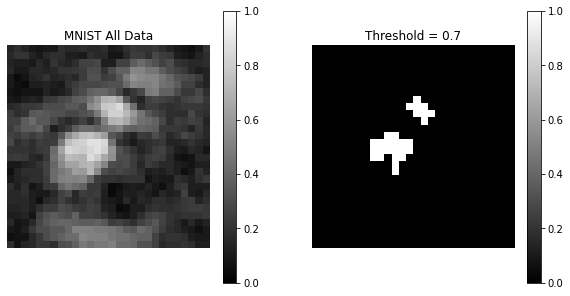

In [11]:
plot_threshold(b=b, thres = 0.7)